# Customer segregation for marketing strategy
<br>

___

#### Context
This data set is created only for the learning purpose of the customer segmentation concepts, also known as market basket analysis. I will demonstrate this by using unsupervised ML technique (KMeans Clustering Algorithm) in the simplest form.

#### Content
You are owing a supermarket mall and through membership cards, you have some basic data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data. The data for this project is obtained from this [Kaggle page](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

#### Problem Statement
You own the mall and want to understand the customers and how they can be targeted so that the sense can be given to marketing team to plan strategy.

#### Acknowledgements
From Udemy's Machine Learning A-Z course

___


#### Proposed Solution
We aim to cluster customers and create customer personas to better describe the type of customers we have. To do so, we use KMeans clustering to find an optimal number of clusters. We can create personas by looking at the mean value of features within each cluster. Finally, we make marketing strategy recommendations.

#### Outline:
1. [Import modules](#import-modules)
2. [Load Data](#load-data)
3. [Early Visualization](#early-viz)
4. [Data Cleaning](#data-cleaning)
5. [Feature Standardization](#feature-standardization)
6. [KMeans Clustering](#kmeans)
7. [Feature Engineering](#feature-engineering)
8. [Analyzing Clusters](#analyzing-clusters)
9. [Customer Profiles](#customer-profiles)
10. [Marketing Strategy](#marketing-strategy)

___


<a id='import-modules'></a>
#### 1. Import modules

In [1]:
# We start by importing modules
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

# Axes3D for 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# Seaborn for better visualizations
import seaborn as sns

# KMeans for clustering
from sklearn.cluster import KMeans
# StandardScaler for feature scaling
from sklearn.preprocessing import StandardScaler
# Silhouette score for optimal cluster number selection
from sklearn.metrics import silhouette_score
# Principle component analysis for feature engineering
from sklearn.decomposition import PCA

<a id='load-data'></a>
#### 2. Load Data

In [3]:
# Define path to the data file
path2data = Path('/Users/saadjansari/Documents/Projects/Personal/CustomerSegmentation/Mall_Customers.csv')

# Read to a pandas dataframe if the file exists
if Path.exists( path2data):
    print('Reading {}...\nLoading as a pandas dataframe!'.format(path2data.name))
    customers = pd.read_csv(path2data)
    print('')
else:
    print('Specified path: {0} does not exist!'.format(path2data))

Reading Mall_Customers.csv...
Loading as a pandas dataframe!



<a id='early-viz'></a>
#### 3. Early visualization
We start by looking at a few values of the dataset

In [4]:
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We see that there are 5 columns:
* CustomerID
* Gender
* Age
* Annual Income (k$)
* Spending Score (1-100)

Customer ID, while useful for marketing, is irrelevant for the purposes of segregation and will remain unused. Other than that, there are a total of __4 features__. _Gender_ is a categorical feature (such that it takes on categorical values of either 'Male' or 'Female') and will require one-hot encoding to transform it to a numerical feature (such that it takes on values of either 0 or 1).

A good idea at this stage is to look for missing data. This will determine if data cleaning is required on this particular dataset. Here is a heatmap of the entire dataset, where missing values are shown in _white_. In this case, there are no missing values, and data cleaning is not required.

/var/folders/k2/846fdd3j7xv_l73f5jjd7h880000gp/T/ipykernel_60759/1418727044.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(ax.get_xticklabels(), Rotation=45 )


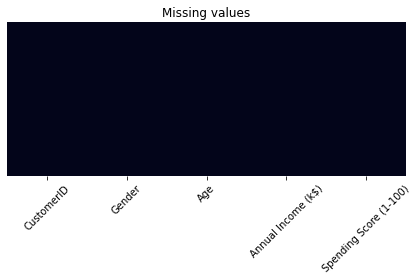

In [12]:
# features that we will use
features = ['Gender','Age','Annual Income (k$)', 'Spending Score (1-100)']

# Let plot missing values
fig,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(customers.isnull(), yticklabels=False, cbar=False,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), Rotation=45 ) 
ax.set_title("Missing values");
plt.tight_layout()
plt.savefig(path2data.parent / '3_missing_vals.png',bbox_inches="tight")

Before we begin clustering, it can sometimes be useful to visualize the entire dataset. This, ofcourse, can be unfeasible if the number of rows or columns is large. However, in this case, the dataset is small enough to visualize.
For the purposes of this visualization, since _Gender_ needs to be transformed, we will not use it.

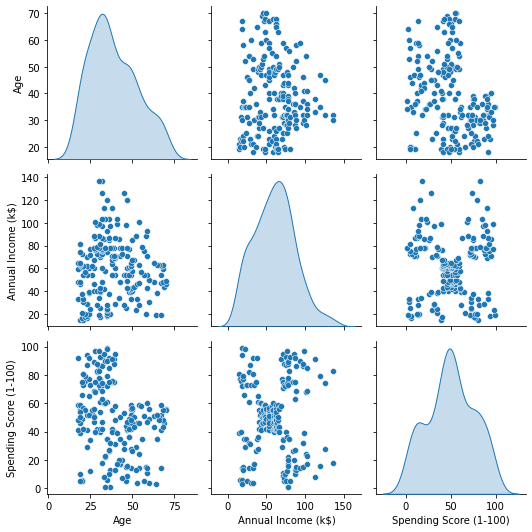

In [13]:
sns.pairplot(customers, vars=features[1:], diag_kind='kde')
plt.tight_layout()
plt.savefig(path2data.parent / '3_pairplot.png',bbox_inches="tight")

There are a few relationships that are immediately obvious. 
1. __Top-Right__: Younger people (<40) spend more than older people (>40).
2. __Middle-Right__: Strong clustering behavior is evident. There are possibly 4-5 groups present here.
<br><br>

<a id='data-cleaning'></a>
#### 4. Data cleaning
There are no missing values, and data cleaning is not required. We can proceed to feature standardization.
<br><br>

<a id='feature-standardization'></a>
#### 5. Feature standardization
There are a few tasks we need to accomplish.
* Standardization of features. Currently, features have different means and variances and clustering can be biased towards features with biggest variances. Standardization scales the features to have a mean of 0 and a variance of 1. This ensures that all features have an equal weighting during clustering.
* Dummy variable encoding for _Gender_. This categorical feature needs to be transformed into a numerical feature.

In [14]:
# Being by extracting the Gender feature
gender = customers['Gender']
customers_standard = customers[features].drop(columns=['Gender'])
customers_standard.head()

# Standardize the numerical variables
scaler = StandardScaler()
X_std = scaler.fit_transform(customers_standard)
customers_standard = pd.DataFrame( X_std, columns=customers_standard.columns)
customers_standard['Gender'] = gender
customers_standard.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,Male
1,-1.281035,-1.738999,1.195704,Male
2,-1.352802,-1.700830,-1.715913,Female
3,-1.137502,-1.700830,1.040418,Female
4,-0.563369,-1.662660,-0.395980,Female


In [15]:
# Dummy variable encoding
# Pandas get_dummies creates a one-hot-encoding for each categorical variable 
customers_standard = pd.get_dummies(customers_standard)
# We drop the redundant variable, since Gender_Male=1 indicates male and 
# Gender_Male=0 indicates a female
customers_standard = customers_standard.drop(['Gender_Female'],axis=1)
customers_standard.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


<a id='kmeans'></a>
#### 6. Kmeans clustering

The data we have is unlabeled and is an ideal candidate for unsupervised classification. A good way to find clusters in this kind of data is [KMeans](https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203). This algorithm starts with a pre-defined number of clusters and random centroids. Data points are assigned to clusters based on closest distance. We iterate by finding new centroids for each cluster and repeating the cluster assignment process. Iterations continue until cluster assignments do not change.
<br>
An important variable of choice is the number of clusters. This is often unknown. We will try a range of values for this variable and determine the optimal one using the [Silhoutte Score](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py). Silhoutte coefficients measure how fat a point in one cluster is to points in neighboring clusters. Large values (close to +1) indicate that a cluster is far away from neighboring clusters. Values close to 0 indicate that a cluster is close to the decision boundary between neighboring clusters. Negative values (close to -1) indicate that clustering may have been incorrect.

For n_clusters = 2 The average silhouette_score is : 0.3031976564160757
For n_clusters = 3 The average silhouette_score is : 0.31384595454509323
For n_clusters = 4 The average silhouette_score is : 0.3502702043465398
For n_clusters = 5 The average silhouette_score is : 0.34977050035201074
For n_clusters = 6 The average silhouette_score is : 0.356485834425401
For n_clusters = 7 The average silhouette_score is : 0.3359706123975697
For n_clusters = 8 The average silhouette_score is : 0.3322029599065154
For n_clusters = 9 The average silhouette_score is : 0.31025859487324325
For n_clusters = 10 The average silhouette_score is : 0.3191955986875477
For n_clusters = 11 The average silhouette_score is : 0.3146459180709924
For n_clusters = 12 The average silhouette_score is : 0.3240427535843864
For n_clusters = 13 The average silhouette_score is : 0.3294193273056014
For n_clusters = 14 The average silhouette_score is : 0.3301681191128894


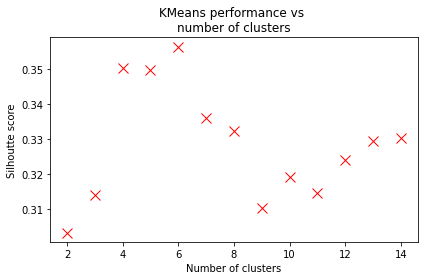

In [17]:
# Define range of clusters to test
range_n_clusters = range(2,15)

sil_scores = []
for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value
    clusterer = KMeans( n_clusters=n_clusters, 
                       init='k-means++', 
                       max_iter=300, 
                       n_init=10, 
                       random_state=10)
    cluster_labels = clusterer.fit_predict(customers_standard)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(customers_standard, cluster_labels)
    sil_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
# Plot the silhoute score vs n_clusters
plt.plot( range_n_clusters, sil_scores, 'rx', ms=10)
plt.title('KMeans performance vs \nnumber of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.tight_layout()
plt.savefig(path2data.parent / '6_silhoutte.png',bbox_inches="tight")

While the best Silhoutte score is achieved with __6__ clusters, a very decent score of 0.35 is achieved with __4__ clusters, and we will stick to that.<br>
Let visualize the data, and this time color it by label. Lets see if clustering led to groups that pass the _eye test_.

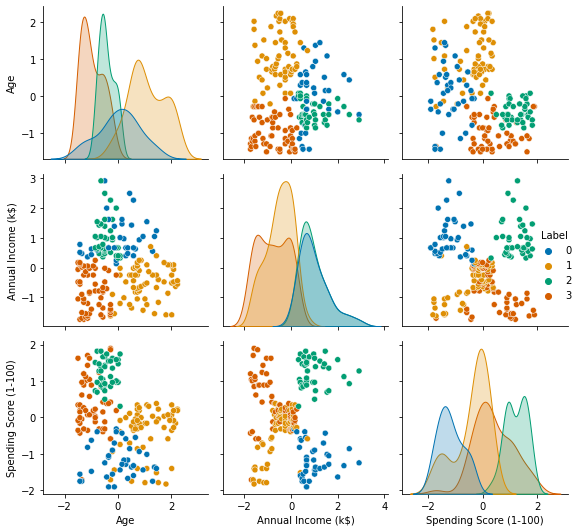

In [22]:
n_clusters = 4
kmeans = KMeans( n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit( customers_standard)
customers_standard['Label'] = kmeans.fit_predict( customers_standard)
sns.pairplot(customers_standard, 
             vars=features[1:],
             hue="Label", diag_kind='kde',
            palette='colorblind')
plt.tight_layout()
plt.savefig(path2data.parent / '6_kmeans_viz.png',bbox_inches="tight")

# Define a 3D plotting function
def plot3d_comparison(df, angle1=30, angle2=185):
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df["Age"][df.Label == 0], 
               df["Annual Income (k$)"][df.Label == 0], 
               df["Spending Score (1-100)"][df.Label == 0], 
               c='blue', s=60)
    ax.scatter(df["Age"][df.Label == 1], 
               df["Annual Income (k$)"][df.Label == 1], 
               df["Spending Score (1-100)"][df.Label == 1], 
               c='red', s=60)
    ax.scatter(df["Age"][df.Label == 2], 
               df["Annual Income (k$)"][df.Label == 2], 
               df["Spending Score (1-100)"][df.Label == 2], 
               c='green', s=60)
    ax.scatter(df["Age"][df.Label == 3], 
               df["Annual Income (k$)"][df.Label == 3], 
               df["Spending Score (1-100)"][df.Label == 3], 
               c='orange', s=60)
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.zaxis.set_ticks([])
    ax.view_init(angle1, angle2)

# plot3d_comparison(customers_standard, angle1=30,angle2=185)

# 3D animation creator
def plot3D_comparison_animation(df, cols=['red','green','blue','orange'],
                                savename='animation.mp4'):
    # Create a figure and a 3D Axes
    fig = plt.figure(figsize=(21,10))
    ax = Axes3D(fig)
    
    def init():
        ax.scatter(df["Age"][df.Label == 0], 
                   df["Annual Income (k$)"][df.Label == 0], 
                   df["Spending Score (1-100)"][df.Label == 0], 
                   c=cols[0], s=60)
        ax.scatter(df["Age"][df.Label == 1], 
                   df["Annual Income (k$)"][df.Label == 1], 
                   df["Spending Score (1-100)"][df.Label == 1], 
                   c=cols[1], s=60)
        ax.scatter(df["Age"][df.Label == 2], 
                   df["Annual Income (k$)"][df.Label == 2], 
                   df["Spending Score (1-100)"][df.Label == 2], 
                   c=cols[2], s=60)
        ax.scatter(df["Age"][df.Label == 3], 
                   df["Annual Income (k$)"][df.Label == 3], 
                   df["Spending Score (1-100)"][df.Label == 3], 
                   c=cols[3], s=60)
        # make the panes transparent
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.zaxis.set_ticklabels([])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.zaxis.set_ticks([])
        return fig,

    def animate(i):
        ax.view_init(elev=10., azim=i)
        return fig,

    # Animate
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=360, interval=20, blit=True)
    # Save
    anim.save(savename, fps=30, extra_args=['-vcodec', 'libx264'])
    
# plot3d_comparison(customers_standard)
# plot3D_comparison_animation(customers_standard, savename='kmeans_animation.mp4')

There is definitely some segregation visbile. Looking back at what we saw earlier:
1. __Top-Right__: Younger people (_Red, Orange_) tend to spend more than older people (_Blue, Green_).
2. __Middle-Right__: All colors have decent separation. However, there is a good degree of overlap between colors, e.g. _Orange_ and _Green_.
<br>

This calls for feature engineering in order to improve our features.

<a id='feature-engineering'></a>
#### 7. Feature Engineering

We use [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) (Principle Component Analysis) to find new features with the biggest eigenvalues in the our 4D feature space. PCA is a useful technique for finding better features and reducing the overall dimensionality.<br><br>
We will use attempt to find 4 PCA features.

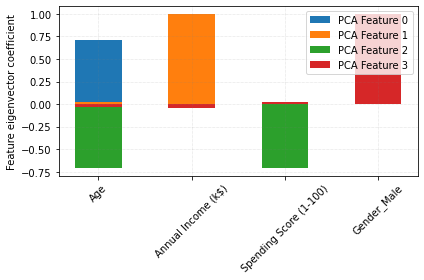

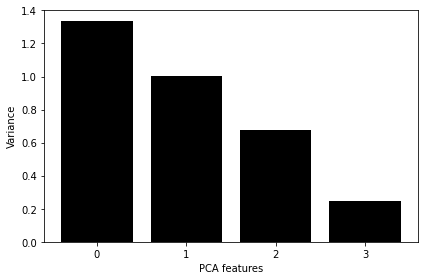

In [24]:
# Principle component analysis
customers_PCA = customers_standard.drop(columns=['Label'])
pca = PCA(n_components=4)
principalComponents = pca.fit_transform( customers_PCA)

# Display PCA features
fig, ax = plt.subplots()
for jf in range(pca.n_components_):
    ax.bar(customers_PCA.columns, pca.components_[jf,:], 0.5, label='PCA Feature {}'.format(jf))
ax.set(ylabel='Feature eigenvector coefficient')
plt.xticks(rotation=45)
plt.legend()
plt.grid(linestyle=':', linewidth='0.5', color='gray', alpha=0.5)
plt.tight_layout()
plt.savefig(path2data.parent / '7_pca_components.png',bbox_inches="tight")

fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), pca.explained_variance_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance')
plt.xticks( range(pca.n_components_) )
plt.tight_layout()
plt.savefig(path2data.parent / '7_pca_variance.png',bbox_inches="tight")

customers_PCA = pd.DataFrame(principalComponents)

Lets use the silhoutte score to determine the ideal number of clusters

For n_clusters = 2 The average silhouette_score is : 0.38464007591863236
For n_clusters = 3 The average silhouette_score is : 0.3647561194178525
For n_clusters = 4 The average silhouette_score is : 0.42981848621678176
For n_clusters = 5 The average silhouette_score is : 0.3609872459632051
For n_clusters = 6 The average silhouette_score is : 0.355704646533076
For n_clusters = 7 The average silhouette_score is : 0.3229687592635864
For n_clusters = 8 The average silhouette_score is : 0.31631382826367294
For n_clusters = 9 The average silhouette_score is : 0.27489209088175115
For n_clusters = 10 The average silhouette_score is : 0.2877785633432173
For n_clusters = 11 The average silhouette_score is : 0.28452774862558955
For n_clusters = 12 The average silhouette_score is : 0.284539430416353
For n_clusters = 13 The average silhouette_score is : 0.3223622480742067
For n_clusters = 14 The average silhouette_score is : 0.292438153251198


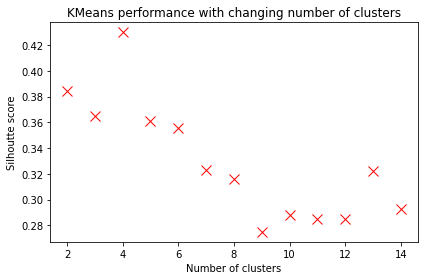

In [25]:
# Define range of clusters to test
range_n_clusters = range(2,15)

sil_scores = []
for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value
    clusterer = KMeans( n_clusters=n_clusters, 
                       init='k-means++', 
                       max_iter=300, 
                       n_init=10, 
                       random_state=10)
    cluster_labels = clusterer.fit_predict(customers_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(customers_standard, cluster_labels)
    sil_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
# Plot the silhoute score vs n_clusters
plt.plot( range_n_clusters, sil_scores, 'rx', ms=10)
plt.title('KMeans performance with changing number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.tight_layout()
plt.savefig(path2data.parent / '7_pca_silhoutte.png',bbox_inches="tight")

We see that choosing 4 clusters is the best choice. The silhoutte score has jumped to 0.42 from 0.35 due to feature engineering. This is unquestionable evidence of improvement! <br><br>
Let's visualize the features, colored by cluster.

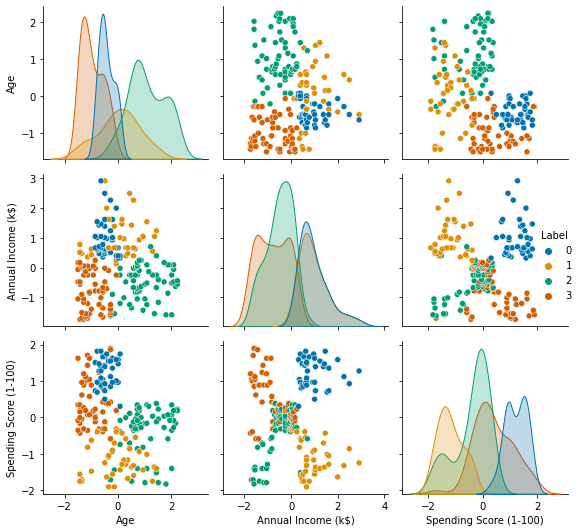

In [26]:
n_clusters = 4
kmeans = KMeans( n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit( customers_PCA)
customers_standard['Label'] = kmeans.fit_predict( customers_PCA)
sns.pairplot(customers_standard, 
             vars=features[1:],
             hue="Label", diag_kind='kde', palette='colorblind')
plt.tight_layout()
plt.savefig(path2data.parent / '7_pca_viz.png',bbox_inches="tight")

# plot3D_comparison_animation(customers_standard, 
#                             cols=['red','green','blue','orange'],
#                             savename='kmeans_PCA_animation.mp4')

<a id='analyzing-clusters'></a>
#### 8. Analyzing clusters
Now each customer has been assigned a cluster, which is given by the _Label_ parameter. <br>
Lets start by looking at the average of all features in each cluster. We see in the bar plot, that the groups have very different features.

In [28]:
clusters = customers_standard.Label
customers_clustered = pd.read_csv(path2data).drop(columns=['CustomerID'])
customers_clustered['cluster'] = clusters

mean_features = customers_clustered.groupby(['cluster'], as_index=False).mean()
std_features = customers_clustered.groupby(['cluster'], as_index=False).std()
mean_features.head()

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,32.875000,86.100000,81.525000
1,1,39.368421,86.500000,19.578947
2,2,53.984615,47.707692,39.969231
3,3,25.438596,40.000000,60.298246


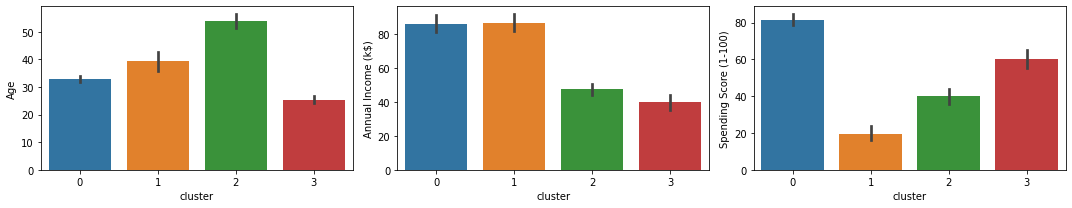

In [29]:
fig,axs = plt.subplots(1,3, figsize=(15,3))
sns.barplot(x="cluster", y="Age", data=customers_clustered, ax=axs[0])
sns.barplot(x="cluster", y="Annual Income (k$)", data=customers_clustered, ax=axs[1])
sns.barplot(x="cluster", y="Spending Score (1-100)", data=customers_clustered, ax=axs[2])
plt.tight_layout()
plt.savefig(path2data.parent / '8_mean_feat_plot.png',bbox_inches="tight")


Here are the trademark features of each cluster:<br><br>
__Cluster 0__ : Middle age, High Annual Income, Low spending score.<br>
__Cluster 1__ : Close to retirement, Average Annual Income, Medium spending score.<br>
__Cluster 2__ : Young Adults, Low Annual Income, High spending score.<br>
__Cluster 3__ : Profesionals, High Annual Income, High spending score.<br>
<br>
Let's do a gender analysis on our clusters to see if there is any significant gender disproportionality.

In [31]:
# Number of male/females in clusters
dk = pd.DataFrame( customers_clustered.groupby(['cluster','Gender'])['Gender'].count() )
dk2 = dk.rename({"Gender": "Count"}, axis=1)
dk2.head(10)

Count
cluster Gender       
0       Female     22
        Male       18
1       Female     19
        Male       19
2       Female     37
        Male       28
3       Female     34
        Male       23

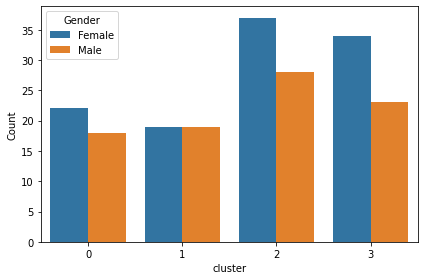

In [32]:
cluster_gender_counts = pd.DataFrame( dk2.index.to_frame().to_numpy(), columns=['cluster','Gender'] )
cluster_gender_counts['Count'] = dk2.Count.to_numpy()
cluster_gender_counts.head()
sns.barplot(x='cluster',y='Count',data=cluster_gender_counts, hue='Gender')
plt.tight_layout()
plt.savefig(path2data.parent / '8_gender_count.png',bbox_inches="tight")

There are clearly a disportionate number of females in the entire dataset. This disportionatlity is carried on to clusters 1,2 and 3. Cluster 0 has equal number of males and females.

<a id='customer-profiles'></a>
#### 9. Customer profiles

Using our observations about the features in each cluster, we can create profiles for customers that come to this supermarket mall. The 4 clusters lead to 4 types of customers.
<br>

| Customer 0  | Customer 1  | Customer 2  | Customer 3  |
|---|---|---|---|
| Middle-aged  |  Approaching retirement |  Young adults |  Middle-aged | 
|  High income | Average income | Average income  | High income  | 
| Low spending |  Average spending |  Average spending |  High income |

<br>

* Customer 0: __Frugal customers__
* Customer 1: __Retiring__
* Customer 2: __Young and reckless__ (target with impulse purchases)
* Customer 3: __Ultra affluent__

<a id='marketing-strategy'></a>
#### 10. Marketing strategy

Using what we know about the customers and their cluster personas, we can devise individualized stategies for marketing to them.

__Frugal customers__: Middle aged individuals who have alot of money but don't spend as much as we want them to. The recommended stategy is to use membership or loyalty programs to appeal to them. Discounts should be employed frequently to appeal to this persona. Marketing can also focus on their guilty pleasures. 

__Retiring__: Slightly older people who are preparing for retirement and spend within their means. To maximize spending from these individuals, any marketing should be kept very simple with a straighforward message. They should be given a sense of pride and respect. To appeal to them, we can use programs like sale days and birthday messages/gifts. Imagery used in marketing should be one that is relatable to the persona. People in ads should be 5-10 years younger than the persona age (since people tend to see themselves as 5-10 years younger).

__Young and reckless__: Overspending young adults. The recommended strategy is promote social change, like climate change awareness, gender inequality, and any other social issues. This persona cares about social good, and marketing/advertisements should be focused on that. Young adults have short attention spans, and so information should be relayed quickly and clearly. Videos are more appealing to young adults than still imagery and should be employed. Marketing should be done on trendy social media platforms like Tiktok and Instagram, instead of Facebook.

__Ultra affluent__: Wealthy spenders. They want to and can afford to buy the best of the best. These are the supermarket's high-value customers and the key is keep them happy and loyal. Relationships and trust are very important to maintain these customers. These individuals should be given the idea of a wealthy and successful business, and imagery should scream 'success'. Advertising supplementary products to past purchases can be beneficial. Companies can start programs like early access, priority checkout, VIP lounges.